In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jampy.legacy.jam_axi_rms import jam_axi_rms
from plotbin.sauron_colormap import register_sauron_colormap
from plotbin.plot_velfield import plot_velfield
from jampy.legacy.jam_axi_rms import jam_axi_rms

path = "/home/carlos/Desktop/Tests JAM- Emcee/"

In [2]:
#Primeiro lemos os dados do pPXF,MGE da fotometria e MGE DM.
y_px, x_px, vel,  disp, chi, sigma_disp = np.loadtxt(path+'Output_Ppxf Second Run.txt', unpack=True) #pPXF
surf_mge, sigma_mge, qObs_mge = np.loadtxt(path+'JAM Input.txt', unpack=True) #Fotometria
pot_DM, sigma_DM, qObs_DM = np.loadtxt(path+'pseudo-DM Input.txt', unpack=True) #DM

In [3]:
#O JAM assume que a galáxia esteja com o seu semi-eixo maior sobre o eixo dos x, bem como o centro no ponto (0,0).
    #Por esse motivo vamos transladar as posições de modo que o centro seja o px com maior dispersão. E depois 
    #vamos rotacionar a galáxia para obter o semi-eixo maior sobre o eixo dos x. Como o find my galaxy retorna o
    #P.A (Position Angle) medido no sentido antihorário a partir do eixo y, precisamos rotacionar os nossos eixos
    #originais de 90°+P.A, para que o semi-eixo maior fique sobre o eixo x. No nosso caso, o P.A retornado é 67.7°

theta = 22.3-90        #ângulo de rotação em graus

#Transalação para que o centro seja o px (0,0)
x_new = x_px - 9.5
y_new = y_px - 9.5

#Rotação
x_rot = ( np.cos(theta*np.pi/180)*x_new + np.sin(theta*np.pi/180)*y_new )
y_rot = ( -np.sin(theta*np.pi/180)*x_new + np.cos(theta*np.pi/180)*y_new )

In [4]:
#Esse bloco não é necessário. Ele apenas verifica se a maior dispersão após a translação se encontra na posição (0,0)
#Além disso, olhamos também para ver se essa posição é mantida após a rotação
print("     x_px   y_px   disp \t   x_new   y_new   disp \t   x_rot   y_rot   disp")

for i in range(len(disp)):
    print("%8.2f%8.2f%8.2f\t%8.2f%8.2f%8.2f\t%8.2f%8.2f%8.2f" % (x_px[i],y_px[i], disp[i],x_new[i],y_new[i],disp[i],x_rot[i],y_rot[i],disp[i]))

     x_px   y_px   disp 	   x_new   y_new   disp 	   x_rot   y_rot   disp
    0.00    0.00  303.61	   -9.50   -9.50  303.61	    5.18  -12.39  303.61
    1.00    0.00  243.74	   -8.50   -9.50  243.74	    5.56  -11.47  243.74
    2.00    0.00  392.32	   -7.50   -9.50  392.32	    5.94  -10.54  392.32
    3.00    0.00  320.58	   -6.50   -9.50  320.58	    6.32   -9.62  320.58
    4.00    0.00  304.89	   -5.50   -9.50  304.89	    6.70   -8.69  304.89
    5.00    0.00  293.97	   -4.50   -9.50  293.97	    7.08   -7.77  293.97
    6.00    0.00  279.72	   -3.50   -9.50  279.72	    7.46   -6.84  279.72
    7.00    0.00  315.84	   -2.50   -9.50  315.84	    7.84   -5.92  315.84
    8.00    0.00  317.13	   -1.50   -9.50  317.13	    8.22   -4.99  317.13
    9.00    0.00  333.10	   -0.50   -9.50  333.10	    8.60   -4.07  333.10
   10.00    0.00  254.56	    0.50   -9.50  254.56	    8.98   -3.14  254.56
   11.00    0.00  307.48	    1.50   -9.50  307.48	    9.36   -2.22  307.48
   12.00    0.00  297.40	 

In [5]:
#Este bloco serve para separarmos apenas os px's internos a um certo raio. Isso leva em conta a elipticidade da galáxia
#Onde fica definido o r nós multiplicamos o valor em px de cada posição por 0.6 pois essa é a px scale, de modo que r tem unidade de arcsec.

x_good = []
y_good = []
disp_good = []
sigma_good = []

for i in range(len(disp)):
    r = np.sqrt((x_rot[i]*0.6)**2 + ((y_rot[i])*0.6/(1-0.24))**2)
    if r < 5:
        x_good.append(x_rot[i])
        y_good.append(y_rot[i])
        disp_good.append(disp[i])
        sigma_good.append(sigma_disp[i])

jam_axi_rms elapsed time sec: 0.69
inc=120.0 beta_z=-0.60 M/L=1 BH=7.00e+09 chi2/DOF=9.24
Total mass MGE: 8.148e+11


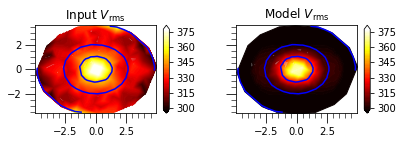

In [6]:
#Aqui é onde realmente é feito o ajuste pelo Jampy

#Definindo os parâmetros do pPXF
xbin = np.array(x_good)*0.6
ybin = np.array(y_good)*0.6

inc = 120.                                           #Assumed galaxy inclination                  
r = np.sqrt(xbin**2 + (ybin/(1-0.24))**2)           #Radius in the plane of the disk
rms = np.sqrt(np.array(disp_good)**2)               #Vrms field in km/s
erms = np.array(sigma_good)                         #1-sigma erro na dispersão

sigmapsf = 0.2420                                   #Sigma psf de onde foram coletados os dados de cinemática, em arcsec
pixsize = 0.6                                       #pixel scale, em px/arcsec, dos dados de cinemática
goodBins =    (r > 0)                           #Informa quais valores de r são bons para gerar o modelo.

#Parâmetros para o modelo JAM
distance = 127.64                                            #Distance in Mpc
mbh = 7e9                                                #Black hole mass in solar masses
#beta = np.array([0.1,0.91, -0.9, -1.7, 0.43, -0.35, 0.32])   #Anisotropy parameter. One for each gaussian component 
beta = np.array([-0.6, -1.0, 0.34, -3.4, 0.39, -0.31, 0.36])
ml = np.array([9.5, 9.5, 8.5, 3.8, 3.4, 3.2, 2.8])           #Mass-to-light ratio in M_sun/L_sun

#Parâmetros do MGE fotométrico
surf_lum = surf_mge               #surface luminosity das gaussianas da fotometria, em unidades de L_sun/pc²
sigma_lum = sigma_mge             #dispersão de cada gaussiana da fotometria, em arcsec.
qobs_lum = qObs_mge               #axial ratio de cada gaussiana da fotometria.


#Potential
    #Neste bloco começamos a definir as componentes do potencial gravitacional. Em um cenário auto-consistente,
    #surf_pot = surf_lum, sigma_pot = sigma_lum, qobs_pot = qObs_lum. Mas pode-se adicionar uma componente de 
    #matéria escura, de modo que as componentes do potencial terão as gaussianas da fotometria + gaussianas do DM.
    #Neste segundo caso, é necessário transformar os valores de luminosidade das surf_lum em valores de massa,
    #multiplicando cada gaussiana da surf_lum por um valor de ml. Após esse passo, podemos adicionar as componentes
    #de DM ao surf_pot. Quando é setado uma ml anterior, é necessário informar a função jam_axi_rms que ml=1. Isso
    #é necessário pois, caso não seja dado um ml ao chamar a função, ela irá calcular o melhor ml e escalonar a
    #solução da Vrms com base neste valor. Por outro lado, se ao chamar a função setamos ml=1, ela usa esse valor 1
    #para escalonar a solução, o que na prática não muda os resultados.
    
surf_pot = surf_mge*ml         #pico do surface potential de cada gaussiana que contribuí para o potencial, em M_sun/pc².
sigma_pot = sigma_mge            #sigma de cada gaussiana presente no surf_pot, em arcsec.
qobs_pot = qObs_mge              #axial ratio de cada gaussiana do potencial.

#Add mge from DM
    #Uma vez que tenhamos multiplicado as componentes luminosas por ml, agora podemos adicionar as componentes
    #gaussianas do perfil de DM. As unidades são as mesmas que as citadas acima.

surf_pot = np.append(surf_pot, pot_DM)
sigma_pot = np.append(sigma_pot, sigma_DM)
qobs_pot = np.append(qobs_pot, qObs_DM )



#------------------------------------- Chamando a função -----------------------------------------------------#
rmsModel, ml, chi2, flux = jam_axi_rms(
        surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
        inc, mbh, distance, xbin, ybin, plot=True, rms=rms, erms=erms, sigmapsf=sigmapsf, goodbins=goodBins,
        beta=beta, pixsize=pixsize, tensor='zz', cmap=plt.cm.hot, colorbar=True, linescolor='b', ml=1, nodots=True)

plt.subplots_adjust(wspace=0.5)

In [23]:
from My_Jampy import JAM

In [24]:
model = JAM(ybin=ybin, xbin=xbin,inc=inc, distance=distance, mbh= mbh, rms=rms, erms=erms, beta=beta, goodbins=goodBins,
                       sigmapsf=sigmapsf, pixsize=pixsize)

In [25]:
print(model.goodbins)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [26]:
ml = np.array([9.5, 9.5, 8.5, 3.8, 3.4, 3.2, 2.8]) 
model.luminosity_component(surf_lum, sigma_lum, qobs_lum, ml=ml)

In [11]:
model.DM_component(pot_DM, sigma_DM, qObs_DM)

jam_axi_rms elapsed time sec: 0.22
inc=120.0 beta_z=-0.60 M/L=1 BH=7.00e+09 chi2/DOF=20
Total mass MGE: 2.984e+11


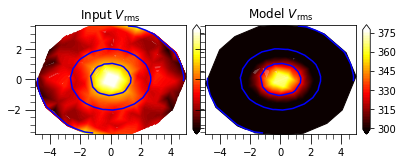

In [27]:
a1, a2, a3, a4 = model.run(quiet=False, plot=True)

jam_axi_rms elapsed time sec: 0.54
inc=120.0 beta_z=-0.60 M/L=1 BH=7.00e+09 chi2/DOF=122
Total mass MGE: 7.098e+11


(array([230.68507999, 231.41554264, 231.16558211, 229.47546114,
        225.92615208, 233.68338577, 234.88582681, 236.27219348,
        237.34457134, 237.47382001, 236.21178815, 233.43159764,
        228.89194816, 236.0866207 , 236.58868026, 237.69993475,
        238.82670144, 239.71579279, 240.33567528, 240.17993557,
        238.15784459, 234.27343475, 228.95230664, 237.82380342,
        237.23940194, 237.06201115, 237.03579766, 237.25706887,
        237.78359947, 238.63777372, 239.63240975, 239.84728829,
        237.43815716, 233.14431323, 238.07006462, 236.59598459,
        235.30071975, 234.91695943, 235.67781594, 236.66262808,
        236.62346268, 237.23221287, 238.55091182, 238.45352191,
        235.50983024, 239.1790867 , 237.27214171, 234.91293058,
        233.7316356 , 235.55676957, 241.02810629, 244.93903711,
        240.88762612, 236.17355863, 236.53245569, 237.75747615,
        236.65448909, 233.94131068, 238.47186205, 236.18935191,
        233.6695806 , 234.1918317 , 239.

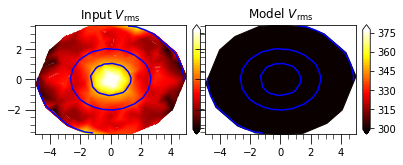

In [14]:
model.run(quiet=False, plot=True)

In [15]:
pot_DM[:] = 300

In [16]:
pot_DM

array([300., 300., 300., 300., 300., 300., 300., 300., 300., 300., 300.,
       300., 300., 300., 300., 300., 300., 300., 300., 300., 300., 300.,
       300., 300., 300., 300., 300., 300., 300.])

In [28]:
model.upt(surf_dm=pot_DM)

ValueError: Dark Matter components were not properly initialized

jam_axi_rms elapsed time sec: 0.56
inc=120.0 beta_z=-0.60 M/L=1 BH=7.00e+09 chi2/DOF=138
Total mass MGE: 3.93e+11


(array([219.43233562, 220.5399742 , 220.41052601, 218.58270545,
        214.67291821, 222.1368011 , 224.21207547, 226.27948068,
        227.74980962, 227.94467057, 226.41716064, 223.08905906,
        217.81588581, 224.57225628, 226.21169655, 228.34181327,
        230.23359444, 231.52570848, 232.13085462, 231.56282643,
        228.80471271, 223.95475783, 217.57777447, 226.04027682,
        226.78510194, 227.9336918 , 229.09589145, 230.19337849,
        231.12212975, 231.84447639, 232.21716047, 231.45054889,
        227.85235251, 222.27422748, 227.16797537, 227.21722251,
        227.47127742, 228.48309915, 230.23468538, 231.59857781,
        231.25073663, 230.97810478, 231.03094596, 229.48450503,
        225.05437938, 227.54021374, 227.20894905, 226.57850904,
        227.19501533, 230.64383658, 237.25036061, 241.49179896,
        236.88571908, 230.93707011, 229.71336184, 229.23017809,
        226.46344198, 222.20598724, 227.43240289, 226.86900395,
        226.27191227, 228.8115887 , 235.

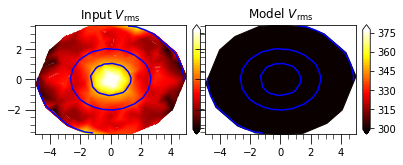

In [19]:
model.run(quiet=False, plot=True)

In [20]:
model.surf_dm

array([300., 300., 300., 300., 300., 300., 300., 300., 300., 300., 300.,
       300., 300., 300., 300., 300., 300., 300., 300., 300., 300., 300.,
       300., 300., 300., 300., 300., 300., 300.])

In [22]:
model.upt(surf_dm=np.array([1,2]))

ValueError: Dark Matter components were not properly initialized